In [41]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape

In [42]:
FIGSIZE = (20, 6)

idx = "datetime"
location = "A001"
target = "global-radiation"
by_day_rolling = pd.read_csv(f"treated-data/by_day_rolling_{location}.csv")
by_day_rolling.tail()

,datetime,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
8649,2024-07-27,1574.985714,0.0,52.533450,20.430170,18.635883,2.158773,4.880364
8650,2024-07-28,1579.614827,0.0,52.746894,20.472865,18.693258,2.179076,4.926391
8651,2024-07-29,1584.033279,0.0,52.905603,20.503824,18.732764,2.178998,4.937862
8652,2024-07-30,1577.208279,0.0,52.776139,20.606056,18.851812,2.164862,4.906910
8653,2024-07-31,1582.137446,0.0,52.026139,20.695937,18.930383,2.172748,4.926702


In [43]:
by_day_rolling[idx] = by_day_rolling[idx].apply(
    lambda d: pd.to_datetime(d, format="%Y-%m-%d")
)
by_day_rolling = by_day_rolling.set_index(idx)
by_day_rolling.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2024-07-27,1574.985714,0.0,52.533450,20.430170,18.635883,2.158773,4.880364
2024-07-28,1579.614827,0.0,52.746894,20.472865,18.693258,2.179076,4.926391
2024-07-29,1584.033279,0.0,52.905603,20.503824,18.732764,2.178998,4.937862
2024-07-30,1577.208279,0.0,52.776139,20.606056,18.851812,2.164862,4.906910
2024-07-31,1582.137446,0.0,52.026139,20.695937,18.930383,2.172748,4.926702


'train len = 7970'

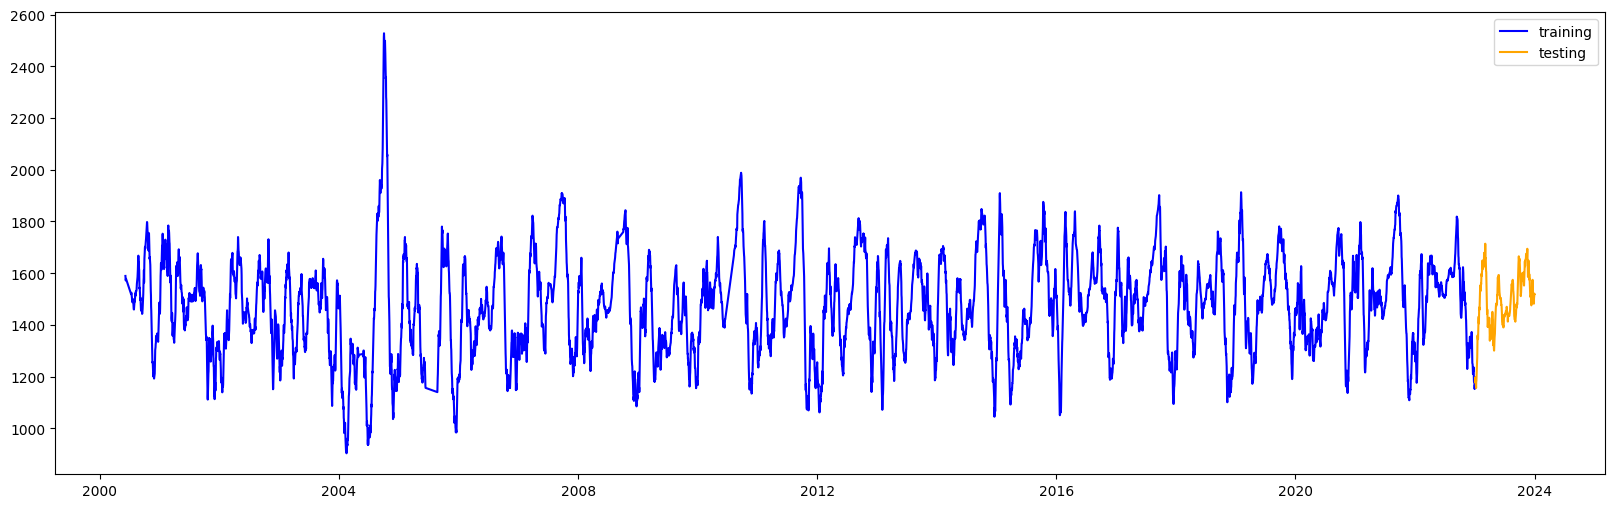

In [44]:
from src.train_test_data import split_datasets, training_threshold, testing_treshold


date_threshold = pd.to_datetime("2023-01-01", format="%Y-%m-%d")
date_upper_threshold = date_threshold + pd.DateOffset(years=1)

train_rolling, test_rolling = split_datasets(
    by_day_rolling, date_threshold, date_upper_threshold
)

plt.figure(figsize=FIGSIZE)
plt.plot(train_rolling[target], color="blue", label="training")
plt.plot(test_rolling[target], color="orange", label="testing")
plt.legend()

f"train len = {train_rolling[target].size}"

In [45]:
xgb_df = by_day_rolling.copy()
xgb_df["lag1"] = (xgb_df.index - pd.DateOffset(years=1)).map(
    train_rolling[target].to_dict()
)
xgb_df.index - pd.DateOffset(years=1)
xgb_df["lag2"] = (xgb_df.index - pd.DateOffset(years=2)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag3"] = (xgb_df.index - pd.DateOffset(years=3)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag4"] = (xgb_df.index - pd.DateOffset(years=4)).map(
    train_rolling[target].to_dict()
)
# xgb_df["lag_history"] = xgb_df.index.day_of_year.map(all_years[target].to_dict())

xgb_df["date"] = xgb_df.index

xgb_df["doy"] = xgb_df["date"].apply(lambda d: d.day_of_year)
xgb_df["woy"] = xgb_df["date"].apply(lambda d: d.date().isocalendar()[1])
xgb_df["month"] = xgb_df["date"].apply(lambda d: d.month)

xgb_df.tail()

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,lag1,lag2,lag3,lag4,date,doy,woy,month
datetime,,,,,,,,,,,,,,,
2024-07-27,1574.985714,0.0,52.533450,20.430170,18.635883,2.158773,4.880364,NaN,1604.818040,1596.974107,1582.910714,2024-07-27,209,30,7
2024-07-28,1579.614827,0.0,52.746894,20.472865,18.693258,2.179076,4.926391,NaN,1610.066850,1599.931845,1577.261722,2024-07-28,210,30,7
2024-07-29,1584.033279,0.0,52.905603,20.503824,18.732764,2.178998,4.937862,NaN,1613.041552,1600.931250,1583.790888,2024-07-29,211,31,7
2024-07-30,1577.208279,0.0,52.776139,20.606056,18.851812,2.164862,4.906910,NaN,1611.043040,1601.679762,1601.829579,2024-07-30,212,31,7
2024-07-31,1582.137446,0.0,52.026139,20.695937,18.930383,2.172748,4.926702,NaN,1611.571016,1604.774702,1609.146955,2024-07-31,213,31,7


In [46]:
feats = ["doy", "woy", *[c for c in xgb_df.columns if "lag" in c]]
# for c in xgb_df.columns:
#     if c == target:
#         continue
#     if abs(xgb_df.corr()[target][c]) >= 0.5:
#         feats.append(c)
print(feats)

xgb_train = xgb_df.loc[training_threshold(xgb_df.index, date_threshold)]
xgb_test = xgb_df.loc[
    testing_treshold(xgb_df.index, date_threshold, date_upper_threshold)
]


def split_x_y_xgb(df, feats, target):
    return df.loc[df[target].notna(), feats], df.loc[df[target].notna(), target]


X_train, y_train = split_x_y_xgb(xgb_train, feats, target)
X_test, y_test = split_x_y_xgb(xgb_test, feats, target)

len(X_test), len(X_train)

['doy', 'woy', 'lag1', 'lag2', 'lag3', 'lag4']


(365, 8050)

In [47]:
reg = xgb.XGBRegressor(
    base_score=1.0,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=500,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.1,
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:1340.45929	validation_1-rmse:1350.04019
[100]	validation_0-rmse:121.57476	validation_1-rmse:158.94266
[200]	validation_0-rmse:108.56150	validation_1-rmse:165.00593
[300]	validation_0-rmse:100.26286	validation_1-rmse:167.89402
[400]	validation_0-rmse:93.78301	validation_1-rmse:173.67330
[500]	validation_0-rmse:88.68696	validation_1-rmse:174.17886
[559]	validation_0-rmse:86.06550	validation_1-rmse:176.12289


XGBRegressor(base_score=1.0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: >

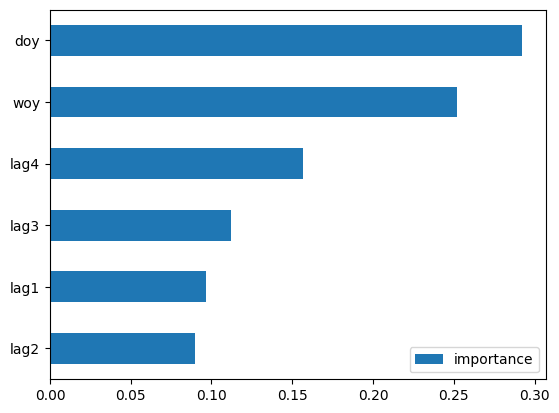

In [48]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
).sort_values("importance")

feature_importance.plot(kind="barh")

In [49]:
xgb_prediction = reg.predict(X_test)

prediction = pd.DataFrame(
    data=xgb_prediction, index=X_test.index, columns=["prediction"]
)
prediction = prediction.merge(
    test_rolling.loc[:, target],
    left_index=True,
    right_index=True,
)

'xgb error = 0.0840%'

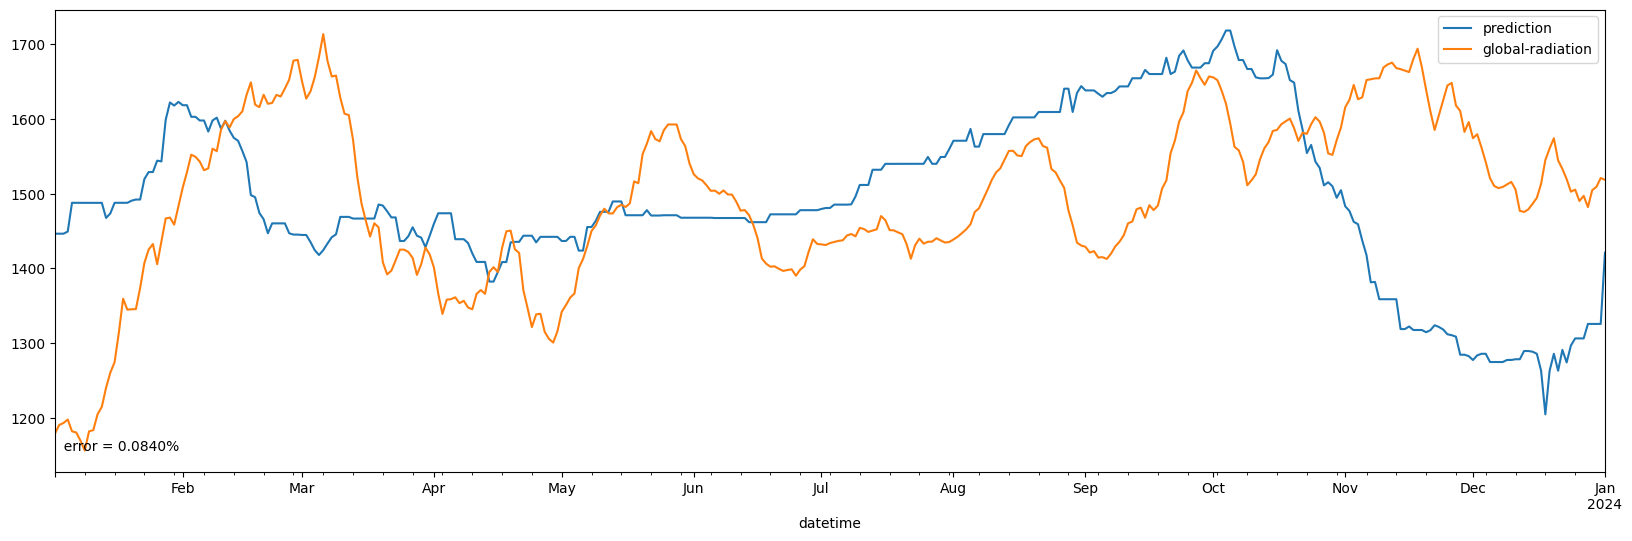

In [50]:
xgb_error = mape(prediction[target], prediction.prediction)
ax = prediction.plot(figsize=FIGSIZE)
ax.text(prediction.index.min(), prediction.min(None), f"  error = {xgb_error:.4f}%")

f"xgb error = {xgb_error:.4f}%"

In [51]:
from src.forecasting.xgb import XGBForecaster

fc = XGBForecaster(
    by_day_rolling, date_threshold, date_upper_threshold, target, idx, mape
)

In [52]:
error = fc.evaluate_model()

[0]	validation_0-rmse:1342.43488	validation_1-rmse:1350.05800
[99]	validation_0-rmse:124.52791	validation_1-rmse:164.46900


Text(0.5, 0.98, 'A001')

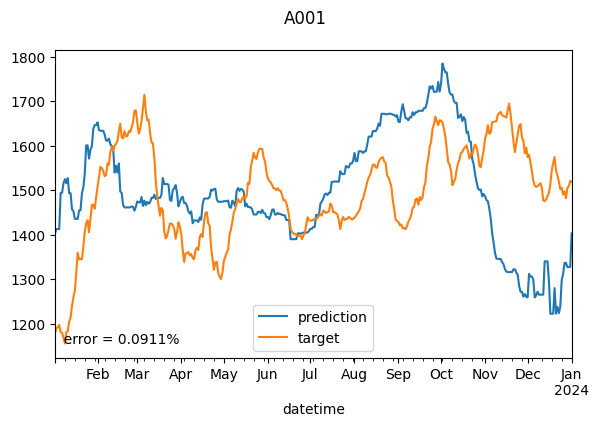

In [53]:
ax = fc.prediction.rename(columns={target: "target"}).plot(figsize=(FIGSIZE[0] / 3, 4))
ax.text(prediction.index.min(), prediction.min(None), f"  error = {error:.4f}%")
plt.suptitle(location)